In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Particle classification (MODEL)

This notebook contains the same code as in `protopipe.scripts.model_diagnostic`.
It should be used to test the performance of the trained model **before** use it to estimate the particle type of DL2 events.

In fact, what happens in a *protopipe* analysis is that part of the TRAINING sample is used for *testing* the models to get some preliminary diagnostics.
This notebook shows this camera-wise preliminary diagnostics.

Settings and setup of the plots are done using the same configuration file used for training the model.

**Developers**  
Please, if you have any contribution regarding this part, do it here and not in the relevant sections of the main code, which are now discontinued.

## Table of contents

* [Feature importance](#Feature-importance)
* [Feature distributions](#Feature-distributions)
* [Boosted Decision Tree Error rate](#Boosted-Decision-Tree-Error-rate)
* [Model output](#Model-output)
* [Energy-dependent distributions](#Energy-dependent-distributions)
* [Energy-dependent ROC curves](#ROC-curve-variation-on-test-sample)

## Imports
[back to top](#Table-of-contents)

In [2]:
import gzip
import glob
from os import path

import pickle
import joblib
import yaml
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'figure.max_open_warning': 0})

## Functions and classes
[back to top](#Table-of-contents)

In [3]:
def load_config(name):
    """Load YAML configuration file."""
    try:
        with open(name, "r") as stream:
            cfg = yaml.load(stream, Loader=yaml.FullLoader)
    except FileNotFoundError as e:
        print(e)
        raise
    return cfg

In [4]:
def load_obj(name ):
    """Load object in binary"""
    with gzip.open(name, 'rb') as f:
        return pickle.load(f)

In [5]:
def plot_hist(ax, data, nbin, limit, norm=False, yerr=False, hist_kwargs={}, error_kw={}):
    """Utility function to plot histogram"""
    bin_edges = np.linspace(limit[0], limit[-1], nbin + 1, True)
    y, tmp = np.histogram(data, bins=bin_edges)
    weights = np.ones_like(y)
    if norm is True:
        weights = weights / float(np.sum(y))
    if yerr is True:
        yerr = np.sqrt(y) * weights
    else:
        yerr = np.zeros(len(y))

    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    width = bin_edges[1:] - bin_edges[:-1]
    ax.bar(centers, y * weights, width=width, yerr=yerr, error_kw=error_kw, **hist_kwargs)

    return ax

In [6]:
def plot_distributions(feature_list,
                       data_list,
                       nbin=30,
                       hist_kwargs_list={},
                       error_kw_list={},
                       ncols=2):
    """Plot feature distributions for several data set. Returns list of axes."""
    n_feature = len(feature_list)
    nrows = int(n_feature / ncols) if n_feature % ncols == 0 else round((n_feature + 1) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, colname in enumerate(feature_list):
        ax = axes[i]

        # Range for binning
        range_min = min([data[colname].min() for data in data_list])
        range_max = max([data[colname].max() for data in data_list])
        myrange = [range_min, range_max]

        for j, data in enumerate(data_list):
            ax = plot_hist(
                ax=ax, data=data[colname], nbin=nbin, limit=myrange,
                norm=True, yerr=True,
                hist_kwargs=hist_kwargs_list[j],
                error_kw=error_kw_list[j]
            )

        ax.set_xlabel(colname)
        ax.set_ylabel('Arbitrary units')
        ax.legend(loc='upper left')
        ax.grid()
    plt.tight_layout()

    return fig, axes

In [7]:
def plot_roc_curve(ax, model_output, y, **kwargs):
    """Plot ROC curve for a given set of model outputs and labels"""
    fpr, tpr, _ = roc_curve(y_score=model_output, y_true=y)
    roc_auc = auc(fpr, tpr)
    label = '{} (area={:.2f})'.format(kwargs.pop('label'), roc_auc)  # Remove label
    ax.plot(fpr, tpr, label=label, **kwargs)
    return ax

In [8]:
def get_evt_subarray_model_output(data,
                                  weight_name=None,
                                  keep_cols=['reco_energy'],
                                  model_output_name='score_img',
                                  model_output_name_evt='score'):
    """
    Returns DataStore with keepcols + score/target columns of model at the
    level-subarray-event.
    
    Parameters
    ----------
    data: `~pandas.DataFrame`
        Data frame
    weight_name: `str`
        Variable name in data frame to weight events with
    keep_cols: `list`, optional
        List of variables to keep in resulting data frame
    model_output_name: `str`, optional
        Name of model output (image level)
    model_output_name: `str`, optional
        Name of averaged model output (event level)
    
    Returns
    --------
    data: `~pandas.DataFrame`
        Data frame
    """

    keep_cols += [model_output_name]
    keep_cols += [weight_name]
    new_data = data[keep_cols].copy(deep=True)

    new_data[model_output_name_evt] = np.zeros(len(new_data))
    new_data.set_index(["tel_id"], append=True, inplace=True)

    new_data[model_output_name_evt] = new_data.groupby(["obs_id", "event_id"]).apply(
        lambda g: np.average(g[model_output_name], weights=g[weight_name])
    )

    # Remove columns
    new_data = new_data.drop(columns=[model_output_name])

    # Remove duplicates
    new_data = new_data[~new_data.index.duplicated(keep="first")]

    return new_data

In [9]:
class ModelDiagnostic(object):
    """
    Base class for model diagnostics.
    
    Parameters
    ----------
    model: `~sklearn.base.BaseEstimator`
        Best model
    feature_name_list: list
        List of the features used to buil the model
    target_name: str
        Name of the target (e.g. score, gamaness, energy, etc.)
    """
    def __init__(self, model, feature_name_list, target_name):
        self.model = model
        self.feature_name_list = feature_name_list
        self.target_name = target_name

    def plot_feature_importance(self, ax, **kwargs):
        """
        Plot importance of features
        Parameters
        ----------
        ax: `~matplotlib.axes.Axes`
            Axis
        """
        if ax is None:
            import matplotlib.pyplot as plt
            ax = plt.gca()

        importance = self.model.feature_importances_
        importance, feature_labels = \
            zip(*sorted(zip(importance, self.feature_name_list), reverse=True))

        bin_edges = np.arange(0, len(importance)+1)
        bin_width = bin_edges[1:] - bin_edges[:-1] - 0.1

        ax.bar(bin_edges[:-1], importance, width=bin_width, **kwargs)
        ax.set_xticks(np.arange(0, len(importance)))
        ax.set_xticklabels(feature_labels, rotation=75)

        return ax

    def plot_features(self, data_list,
                      nbin=30,
                      hist_kwargs_list={},
                      error_kw_list={},
                      ncols=2):
        """
        Plot model features for different data set (e.g. training and test samples).
        Parameters
        ----------
        data_list: list
            List of data
        nbin: int
            Number of bin
        hist_kwargs_list: dict
            Dictionary with histogram options
        error_kw_list: dict
            Dictionary with error bar options
        ncols: int
            Number of columns
        """
        return plot_distributions(
            self.feature_name_list,
            data_list,
            nbin,
            hist_kwargs_list,
            error_kw_list, ncols
        )

    def add_image_model_output(self):
        raise NotImplementedError("Please Implement this method")

In [10]:
class ClassifierDiagnostic(ModelDiagnostic):
    """
    Class to plot several diagnostic plot for classification. Assume that positives and
    negatives are respectively labeled as 1 and 0.
    Parameters
    ----------
    model: sklearn.base.BaseEstimator
        Scikit model
    feature_name_list: list
        List of features
    model_output_name: str
        Name of output
    is_output_proba: bool
        If false, `decision_function` will be called, otherwise, predict_proba.
        In the last case we only consider the probability for signal event
    """
    def __init__(self, model, feature_name_list, target_name,
                 data_train, data_test, model_output_name='score', is_output_proba=False):
        super().__init__(model, feature_name_list, target_name)

        self.data_train = data_train
        self.data_test = data_test
        self.model_output_name = model_output_name
        self.is_output_proba = is_output_proba

        # Compute and add model output
        self.data_train = self.add_image_model_output(
            self.data_train,
            col_name=self.model_output_name
        )
        self.data_test = self.add_image_model_output(
            self.data_test,
            col_name=self.model_output_name
        )

    def add_image_model_output(self, data, col_name):
        """Add model output column"""
        if self.is_output_proba is False:
            data[col_name] = self.model.decision_function(data[self.feature_name_list])
        else:  # Interested in signal probability
            data[col_name] = self.model.predict_proba(data[self.feature_name_list])[:,1]
        return data

    def plot_image_model_output_distribution(
            self,
            cut=None,
            nbin=30,
            hist_kwargs_list=[
                {'edgecolor': 'blue', 'color': 'blue', 'label': 'Gamma training sample',
                'alpha': 0.2, 'fill': True, 'ls': '-', 'lw': 2},
                {'edgecolor': 'blue', 'color': 'blue', 'label': 'Gamma test sample',
                'alpha': 1, 'fill': False, 'ls': '--', 'lw': 2},
                {'edgecolor': 'red', 'color': 'red', 'label': 'Proton training sample',
                'alpha': 0.2, 'fill': True, 'ls': '-', 'lw': 2},
                {'edgecolor': 'red', 'color': 'red', 'label': 'Proton test sample',
                'alpha': 1, 'fill': False, 'ls': '--', 'lw': 2}
            ],
            error_kw_list=[
                dict(ecolor='blue', lw=2, capsize=3, capthick=2, alpha=0.2),
                dict(ecolor='blue', lw=2, capsize=3, capthick=2, alpha=1),
                dict(ecolor='red', lw=2, capsize=3, capthick=2, alpha=0.2),
                dict(ecolor='red', lw=2, capsize=3, capthick=2, alpha=1)
                ]
    ):
        """Plot output distribution. Need more output column"""
        if cut is not None:
            data_test = self.data_test.query(cut)
            data_train = self.data_train.query(cut)
        else:
            data_test = self.data_test
            data_train = self.data_train

        return plot_distributions(
            [self.model_output_name],
            [data_train.query('label==1'), data_test.query('label==1'),
             data_train.query('label==0'), data_test.query('label==0')],
            nbin,
            hist_kwargs_list,
            error_kw_list,
            1
        )

## Load models
[back to top](#Table-of-contents)

In [11]:
# Please, if you modify this notebook through a pull request empty these variables before pushing
# Note that these notebooks will show the results on the documentation!
# For this reason, if you plan to use them for your own testing, please work on a copy of this notebook

analysesDir = ""
analysisName = ""

In [12]:
configuration = f"{analysesDir}/{analysisName}/configs/classifier.yaml"

cfg = load_config(configuration)
model_type = cfg["General"]["model_type"]
method_name = cfg["Method"]["name"]

inDir = f"{analysesDir}/{analysisName}/estimators/gamma_hadron_classifier"
cameras = [model.split('/')[-1].split('_')[2] for model in glob.glob(f"{inDir}/{model_type}*.pkl.gz")]

In [13]:
data = {camera : dict.fromkeys(["model", "data_scikit", "data_train", "data_test"]) for camera in cameras} 

for camera in cameras:

    data[camera]["data_scikit"] = load_obj(
                glob.glob(f"{inDir}/data_scikit_{model_type}_{method_name}_*_{camera}.pkl.gz")[0]
                )
    data[camera]["data_train"] = pd.read_pickle(
        glob.glob(f"{inDir}/data_train_{model_type}_{method_name}_*_{camera}.pkl.gz")[0]
                )
    data[camera]["data_test"] = pd.read_pickle(
        glob.glob(f"{inDir}/data_test_{model_type}_{method_name}_*_{camera}.pkl.gz")[0]
    )
    
    modelName = f"{model_type}_*_{camera}_{method_name}.pkl.gz"
    data[camera]["model"] = joblib.load(glob.glob(f"{inDir}/{modelName}")[0])

## Settings and setup
[back to top](#Table-of-contents)

In [14]:
if cfg["Method"]["use_proba"] is True:
    ouput_model_name = "gammaness"
else:
    ouput_model_name = "score"

In [15]:
# Energy (both true and reconstructed)
nbins = cfg["Diagnostic"]["energy"]["nbins"]

energy_edges = np.logspace(
        np.log10(cfg["Diagnostic"]["energy"]["min"]),
        np.log10(cfg["Diagnostic"]["energy"]["max"]),
        nbins + 1,
        True,
    )

In [16]:
# Parameters for energy variation
cut_list = [
    "reco_energy >= {:.2f} and reco_energy <= {:.2f}".format(
        energy_edges[i], energy_edges[i + 1]
    )
    for i in range(len(energy_edges) - 1)
]

In [17]:
diagnostic = dict.fromkeys(cameras)
for camera in cameras:   
    diagnostic[camera] = ClassifierDiagnostic(
                    model=data[camera]["model"],
                    feature_name_list=cfg["FeatureList"],
                    target_name=cfg["Method"]["target_name"],
                    data_train=data[camera]["data_train"],
                    data_test=data[camera]["data_test"],
                    model_output_name=ouput_model_name,
                    is_output_proba=cfg["Method"]["use_proba"],
                )

## Benchmarks
[back to top](#Table-of-contents)

### Feature importance
[back to top](#Table-of-contents)

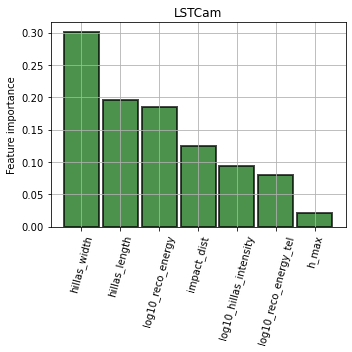

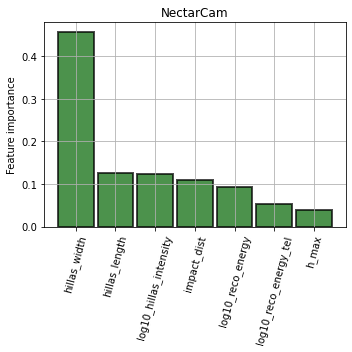

In [18]:
for camera in cameras:
    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax = diagnostic[camera].plot_feature_importance(
        ax,
        **{"alpha": 0.7, "edgecolor": "black", "linewidth": 2, "color": "darkgreen"}
    )
    ax.set_ylabel("Feature importance")
    ax.grid()
    plt.title(camera)
    plt.tight_layout()

### Feature distributions
[back to top](#Table-of-contents)

                                                  LSTCam                                           


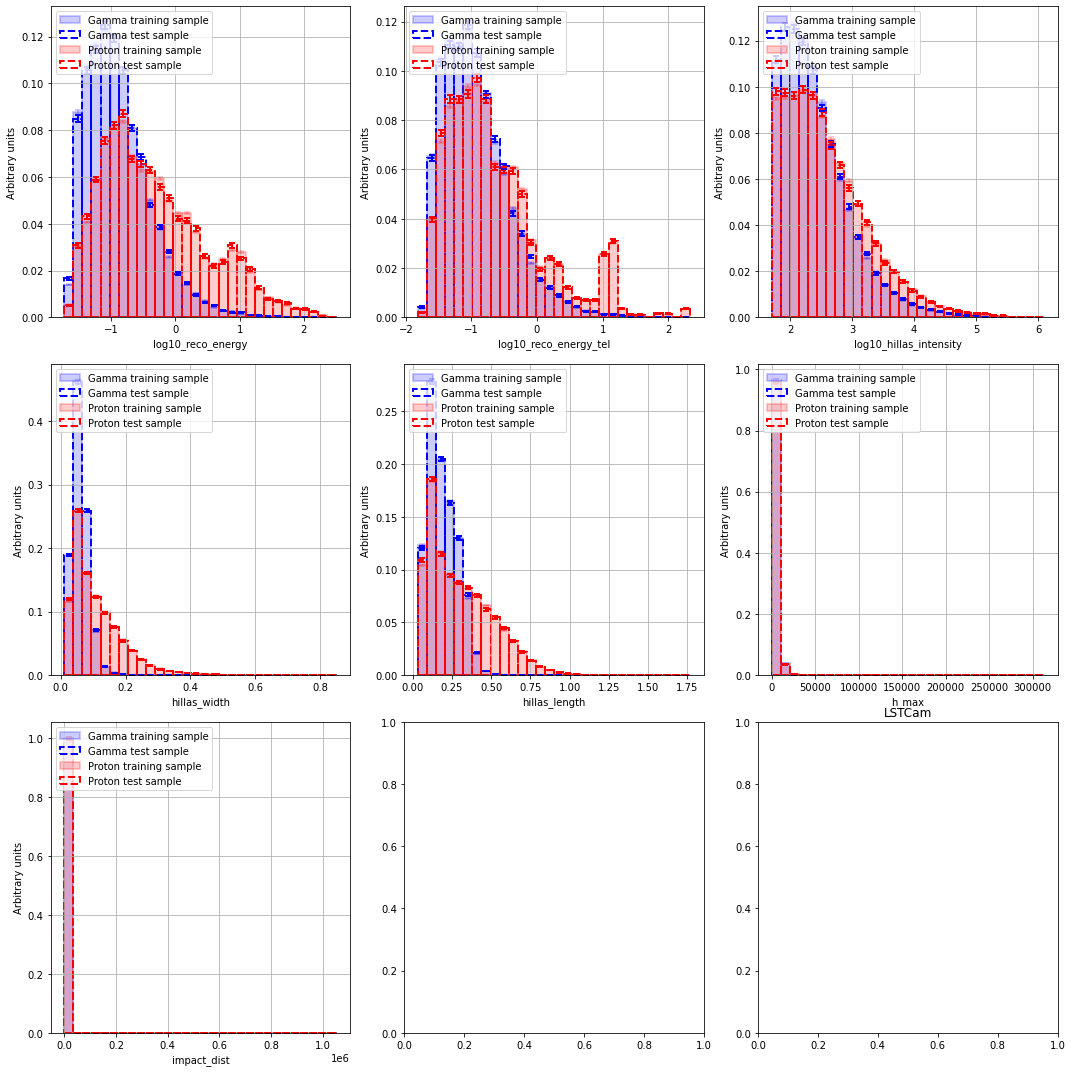

                                                  NectarCam                                           


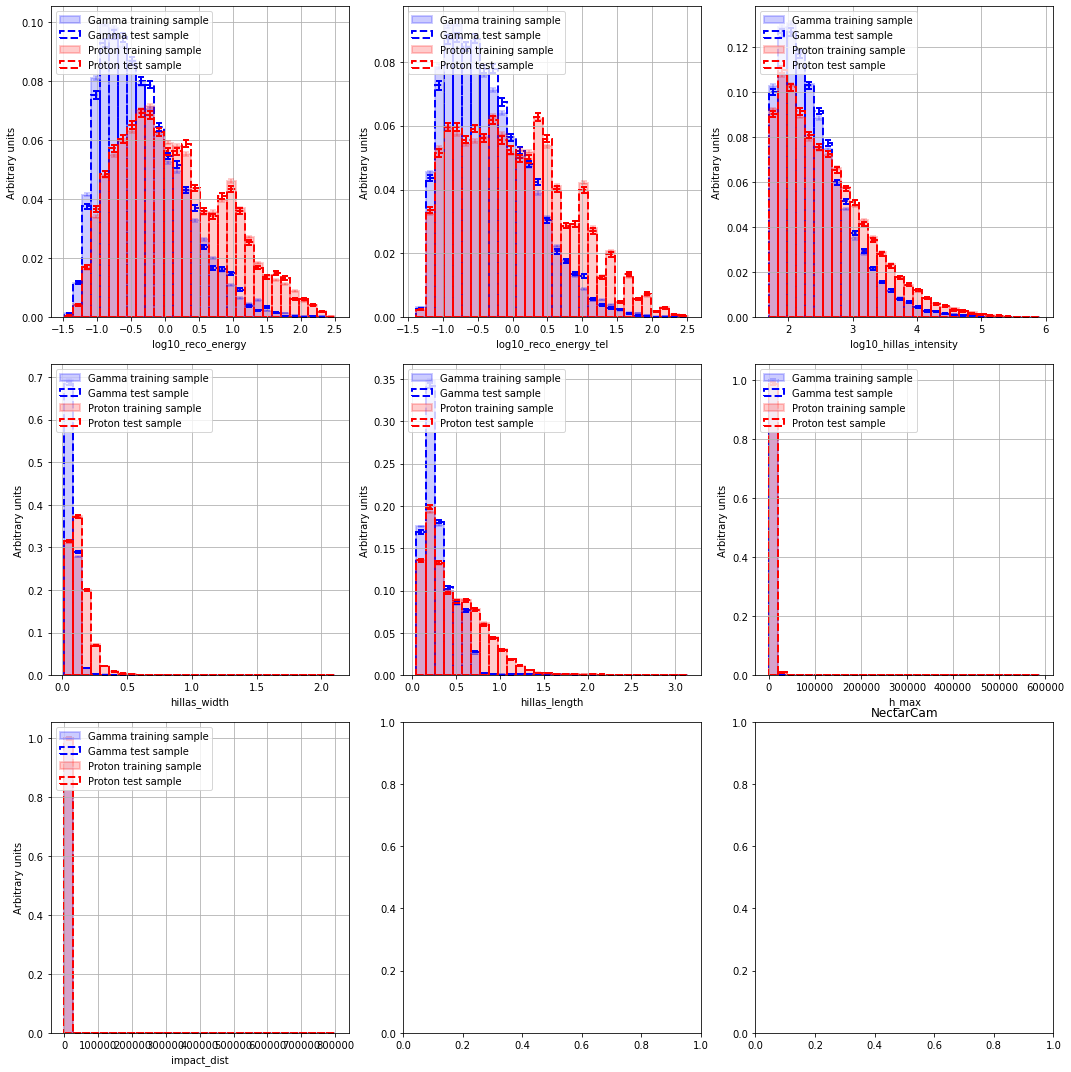

In [19]:
for camera in cameras:
    
    print("              ====================================================================================")
    print(f"                                                  {camera}                                           ")
    print("              ====================================================================================")
    
    fig, axes = diagnostic[camera].plot_features(
                data_list=[
                    data[camera]["data_train"].query("label==1"),
                    data[camera]["data_test"].query("label==1"),
                    data[camera]["data_train"].query("label==0"),
                    data[camera]["data_test"].query("label==0"),
                ],
                nbin=30,
                hist_kwargs_list=[
                    {
                        "edgecolor": "blue",
                        "color": "blue",
                        "label": "Gamma training sample",
                        "alpha": 0.2,
                        "fill": True,
                        "ls": "-",
                        "lw": 2,
                    },
                    {
                        "edgecolor": "blue",
                        "color": "blue",
                        "label": "Gamma test sample",
                        "alpha": 1,
                        "fill": False,
                        "ls": "--",
                        "lw": 2,
                    },
                    {
                        "edgecolor": "red",
                        "color": "red",
                        "label": "Proton training sample",
                        "alpha": 0.2,
                        "fill": True,
                        "ls": "-",
                        "lw": 2,
                    },
                    {
                        "edgecolor": "red",
                        "color": "red",
                        "label": "Proton test sample",
                        "alpha": 1,
                        "fill": False,
                        "ls": "--",
                        "lw": 2,
                    },
                ],
                error_kw_list=[
                    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=0.2),
                    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=1),
                    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=0.2),
                    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=1),
                ],
                ncols=3,
            )
    plt.title(camera)
    #fig.tight_layout()
    plt.show()

### Boosted Decision Tree Error rate
[back to top](#Table-of-contents)

In [20]:
if method_name != "AdaBoostClassifier":
    
    print("The model is not an AdaBoostClassifier")

else:
    
    for camera in cameras:
        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        opt = {"color": "darkgreen", "ls": "-", "lw": 2}
        BoostedDecisionTreeDiagnostic.plot_error_rate(
            ax, model, data_scikit, **opt
        )
        plt.title(camera)
        plt.tight_layout()

        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        BoostedDecisionTreeDiagnostic.plot_tree_error_rate(ax, model, **opt)
        plt.title(camera)
        plt.show()

The model is not an AdaBoostClassifier


### Model output
[back to top](#Table-of-contents)

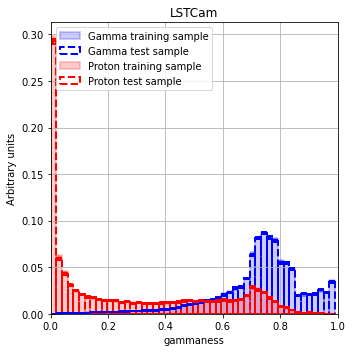

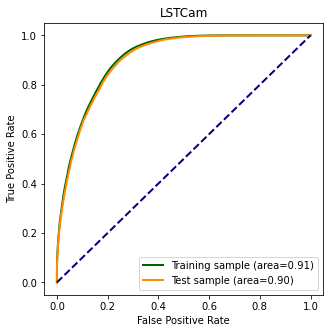

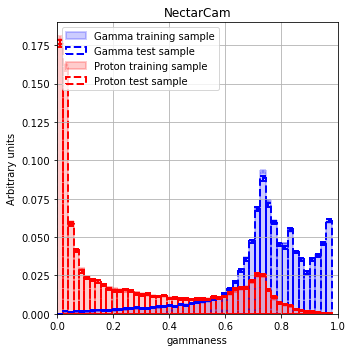

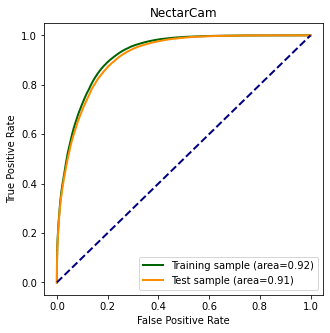

In [21]:
for camera in cameras:

    fig, ax = diagnostic[camera].plot_image_model_output_distribution(nbin=50)
    ax[0].set_xlim([0, 1])
    plt.title(camera)
    fig.tight_layout()

    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    plot_roc_curve(
        ax,
        diagnostic[camera].data_train[diagnostic[camera].model_output_name],
        diagnostic[camera].data_train["label"],
        **dict(color="darkgreen", lw=2, label="Training sample")
    )
    plot_roc_curve(
        ax,
        data[camera]["data_test"][diagnostic[camera].model_output_name],
        diagnostic[camera].data_test["label"],
        **dict(color="darkorange", lw=2, label="Test sample")
    )
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.legend(loc="lower right")
    plt.title(camera)
    plt.show()

## Energy-dependent distributions
[back to top](#Table-of-contents)

                                                  LSTCam                                           


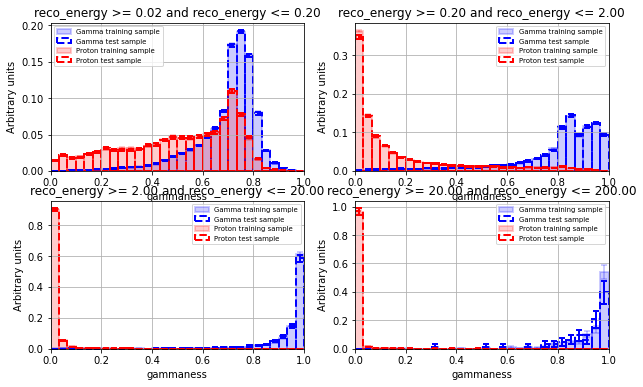

                                                  NectarCam                                           


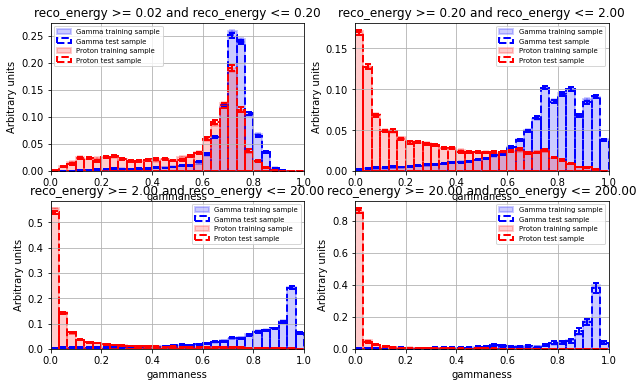

In [22]:
hist_kwargs_list = [
    {
        "edgecolor": "blue",
        "color": "blue",
        "label": "Gamma training sample",
        "alpha": 0.2,
        "fill": True,
        "ls": "-",
        "lw": 2,
    },
    {
        "edgecolor": "blue",
        "color": "blue",
        "label": "Gamma test sample",
        "alpha": 1,
        "fill": False,
        "ls": "--",
        "lw": 2,
    },
    {
        "edgecolor": "red",
        "color": "red",
        "label": "Proton training sample",
        "alpha": 0.2,
        "fill": True,
        "ls": "-",
        "lw": 2,
    },
    {
        "edgecolor": "red",
        "color": "red",
        "label": "Proton test sample",
        "alpha": 1,
        "fill": False,
        "ls": "--",
        "lw": 2,
    },
]

error_kw_list = [
    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=0.2),
    dict(ecolor="blue", lw=2, capsize=3, capthick=2, alpha=1),
    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=0.2),
    dict(ecolor="red", lw=2, capsize=3, capthick=2, alpha=1),
]

n_feature = len(cut_list)
ncols = 2
nrows = (
    int(n_feature / ncols)
    if n_feature % ncols == 0
    else int((n_feature + 1) / ncols)
)

for camera in cameras:
    
    print("              ====================================================================================")
    print(f"                                                  {camera}                                           ")
    print("              ====================================================================================")

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows)
    )
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    data_list = [
        data[camera]["data_train"].query("label==1"),
        data[camera]["data_test"].query("label==1"),
        data[camera]["data_train"].query("label==0"),
        data[camera]["data_test"].query("label==0"),
    ]

    for i, colname in enumerate(cut_list):
        ax = axes[i]

        # Range for binning
        the_range = [0, 1]

        for j, d in enumerate(data_list):
            if len(d) == 0:
                continue

            ax = plot_hist(
                ax=ax,
                data=d.query(cut_list[i])[ouput_model_name],
                nbin=30,
                limit=the_range,
                norm=True,
                yerr=True,
                hist_kwargs=hist_kwargs_list[j],
                error_kw=error_kw_list[j],
            )

        ax.set_xlim(the_range)
        ax.set_xlabel(ouput_model_name)
        ax.set_ylabel("Arbitrary units")
        ax.legend(loc="best", fontsize="x-small")
        ax.set_title(cut_list[i])
        ax.grid()

    plt.show()

## ROC curve variation on test sample
[back to top](#Table-of-contents)

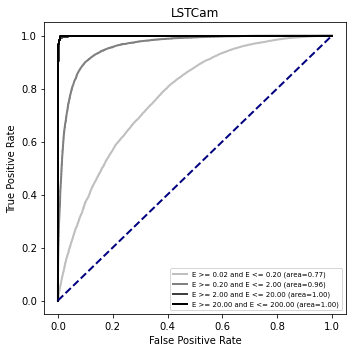

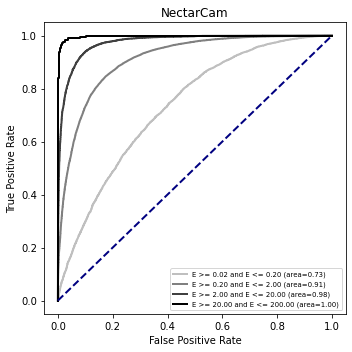

In [23]:
for camera in cameras:
    
    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    color = 1.0
    step_color = 1.0 / (len(cut_list))
    for i, cut in enumerate(cut_list):
        c = color - (i + 1) * step_color

        test_data = data[camera]["data_test"].query(cut)
        if len(test_data) == 0:
            continue

        opt = dict(
            color=str(c),
            lw=2,
            label="{}".format(cut.replace("reco_energy", "E")),
        )
        plot_roc_curve(ax, test_data[ouput_model_name], test_data["label"], **opt)
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_title(camera)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize="x-small")
    plt.tight_layout()